# Turkish Wikipedia, Whitehill model, $\ell_2$-regularized

- dataset: `trwiki`
- model: _whitehill_
- optimizer: _SGD with decaying learning rate_
- regularization: $\ell_2$

The hyperparameters were found using the `trwiki-whitehill-hyperparams` notebook.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import tensorflow as tf

from datetime import datetime
from sklearn.metrics import (
    precision_recall_curve, average_precision_score)
from interank import wikiutils
from interank.models import WhitehillModel
from interank.wikidata import WikiData

%matplotlib inline

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Loading the dataset

In [3]:
%%time
dataset = WikiData("/data/datasets/trwiki")
# dataset.load_bots()

train_data = dataset.get_train_data()
test_data = dataset.get_test_data()

print("=========")
print("Training set: {} edits".format(len(train_data[0])))
print("Test set: {} edits".format(len(test_data[0])))
print("Number of users: {}".format(dataset.n_users))
print("Number of articles: {}".format(dataset.n_articles))
print("=========")

Training set: 7882291 edits
Test set: 532087 edits
Number of users: 1393027
Number of articles: 541476
CPU times: user 16.2 s, sys: 1.38 s, total: 17.5 s
Wall time: 16.3 s


## Setting up the model

- batch size: $5000$
- learning rate: $0.01$
- decay rate: $0.7$
- regularization coeff: $8.0$

The model also includes a global bias, which is not regularized and has a distinct learning rate ($10^{-4}$, decay rate $0.7$).

In [4]:
# Reset graph to run the notebook twice in a row without error.
tf.reset_default_graph()

# Use bias or not
global_bias = True

# Whitehill model
model = WhitehillModel(n_users=dataset.n_users,
                       n_articles=dataset.n_articles,
                       global_bias=global_bias)

# Setup the optimisation procedure
batch_size = 5000
n_batches = math.ceil(len(train_data[0]) / batch_size)
print("Total number of batches: {}".format(n_batches))

# Define the cost
reg_coef = 8.0
# Setup train op.
cost = (-model.log_likelihood
        + (reg_coef/n_batches) * (model.l2_difficulty + model.l2_skill))

if global_bias:
    # SGD with decaying learning rate.
    learning_rate = 0.01
    batch_idx_params = tf.Variable(0, trainable=False)
    learning_rate_params = tf.train.exponential_decay(
        learning_rate=learning_rate,
        global_step=(batch_idx_params * batch_size),
        decay_steps=len(train_data[0]),
        decay_rate=0.7,
        staircase=True
    )
    batch_idx_bias = tf.Variable(0, trainable=False)
    learning_rate_bias = tf.train.exponential_decay(
        learning_rate=1e-4,
        global_step=(batch_idx_bias * batch_size),
        decay_steps=len(train_data[0]),
        decay_rate=0.7,
        staircase=True
    )
    train_params = tf.train.GradientDescentOptimizer(learning_rate_params).minimize(
            cost, global_step=batch_idx_params,
            var_list=[model.skill, model.difficulty])
    train_bias = tf.train.GradientDescentOptimizer(learning_rate_bias).minimize(
            cost, global_step=batch_idx_bias,
            var_list=[model.global_bias])
    train_op = tf.group(train_params, train_bias)

else:  # Without bias
    # SGD with decaying learning rate.
    learning_rate = 0.1
    global_step = tf.Variable(0, trainable=False)
    learning_rate_params = tf.train.exponential_decay(
        learning_rate=learning_rate,
        global_step=global_step,
        decay_steps=len(train_data[0]),
        decay_rate=0.7,
        staircase=True
    )
    train_op = tf.train.GradientDescentOptimizer(learning_rate_params).minimize(cost, global_step=global_step)

# Summaries for Tensorboard
auc_ph = tf.placeholder(tf.float32, name="auc")
tf.summary.scalar("avg_log_loss", model.avg_log_loss)
tf.summary.scalar("area_under_pr_curve", auc_ph)
merged = tf.summary.merge_all()

logdir = '../trained-models/tmp'
folder = "trwiki-basic-regularized_batchsize={}_lr={}_date={}".format(
        batch_size, learning_rate, datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
writer = {
    "train": tf.summary.FileWriter(os.path.join(logdir, folder, "train")),
    "test": tf.summary.FileWriter(os.path.join(logdir, folder, "test")),
}

Total number of batches: 1577


In [5]:
step = 0

feed = {
    "train": {
        model.user_id: train_data[0],
        model.article_id: train_data[1],
        model.quality: train_data[2],
    },
    "test": {
        model.user_id: test_data[0],
        model.article_id: test_data[1],
        model.quality: test_data[2],
    }
}

def evaluate_model(step, bad_edit_threshold=0.5):
    print("### step {}".format(step))
    for which in ("train", "test"):
        avg_log_loss, probs = session.run(
            [model.avg_log_loss, model.probability], feed_dict=feed[which])
        labels = (feed[which][model.quality] < bad_edit_threshold).astype(int)
        auc = average_precision_score(labels, 1 - probs)
        summary = session.run(merged, feed_dict={**feed[which], auc_ph: auc})
        writer[which].add_summary(summary, global_step=step)
        writer[which].flush()
        print("{} set: avg. log-loss = {:.6f}, AUC = {:.3f}".format(
                which, avg_log_loss, auc))

# Initialise Tensorflow's variables
session = tf.Session()
session.run(tf.global_variables_initializer())

# Evalute "empty" model.
evaluate_model(step=step)

### step 0
train set: avg. log-loss = 0.786227, AUC = 0.220
test set: avg. log-loss = 0.594472, AUC = 0.168


## Training the model

In [6]:
%%time
epochs = 30

with session.as_default():
    for i in range(epochs):
        for batch in WikiData.minibatches(train_data, batch_size):
            step += 1
            # Train the model on a batch.
            feed_dict = {
                model.user_id: batch[0],
                model.article_id: batch[1],
                model.quality: batch[2],
            }
            _ = session.run(train_op, feed_dict=feed_dict)

        evaluate_model(step=step)
#         print("global bias: {:.3f}".format(model.global_bias.eval()))

### step 1577
train set: avg. log-loss = 0.513375, AUC = 0.555
test set: avg. log-loss = 0.434457, AUC = 0.479
### step 3154
train set: avg. log-loss = 0.509732, AUC = 0.575
test set: avg. log-loss = 0.432548, AUC = 0.480
### step 4731
train set: avg. log-loss = 0.508069, AUC = 0.588
test set: avg. log-loss = 0.435694, AUC = 0.477
### step 6308
train set: avg. log-loss = 0.507127, AUC = 0.595
test set: avg. log-loss = 0.434739, AUC = 0.476
### step 7885
train set: avg. log-loss = 0.506628, AUC = 0.597
test set: avg. log-loss = 0.435812, AUC = 0.474
### step 9462
train set: avg. log-loss = 0.506292, AUC = 0.597
test set: avg. log-loss = 0.434166, AUC = 0.473
### step 11039
train set: avg. log-loss = 0.506068, AUC = 0.600
test set: avg. log-loss = 0.434015, AUC = 0.473
### step 12616
train set: avg. log-loss = 0.505933, AUC = 0.599
test set: avg. log-loss = 0.435477, AUC = 0.472
### step 14193
train set: avg. log-loss = 0.505840, AUC = 0.603
test set: avg. log-loss = 0.434564, AUC = 0.47

## Qualitative results

In [7]:
with session.as_default():
    skills = model.skill.eval()
    difficulties = model.difficulty.eval()
articles = dataset.get_articles()
users = dataset.get_users()

In [8]:
wikiutils.print_articles_summary(1 / np.exp(difficulties), articles, n=5)

### 5 most difficult articles:
 1 +0.910 Vladimir Lenin bibliyografyasÄ± (1133 edits, 54 users)
    https://tr.wikipedia.org/wiki/Vladimir%20Lenin%20bibliyografyas%C3%84%C2%B1
 2 +0.803 Mehmet GÃ¼leryÃ¼z (445 edits, 38 users)
    https://tr.wikipedia.org/wiki/Mehmet%20G%C3%83%C2%BClery%C3%83%C2%BCz
 3 +0.788 The Texas Chainsaw Massacre karakterleri listesi (344 edits, 56 users)
    https://tr.wikipedia.org/wiki/The%20Texas%20Chainsaw%20Massacre%20karakterleri%20listesi
 4 +0.784 Buffy the Vampire Slayer yan karakterleri listesi (174 edits, 37 users)
    https://tr.wikipedia.org/wiki/Buffy%20the%20Vampire%20Slayer%20yan%20karakterleri%20listesi
 5 +0.772 ZÃ¼mrÃ¼dÃ¼anka YoldaÅlÄ±ÄÄ± (1055 edits, 460 users)
    https://tr.wikipedia.org/wiki/Z%C3%83%C2%BCmr%C3%83%C2%BCd%C3%83%C2%BCanka%20Yolda%C3%85%C2%9Fl%C3%84%C2%B1%C3%84%C2%9F%C3%84%C2%B1

### 5 least difficult articles:
 1 +0.204 Augusto De Luca (148 edits, 26 users)
    https://tr.wikipedia.org/wiki/Augusto%20De%20Luca
 2 +0.239 Ani

In [9]:
wikiutils.print_users_summary(skills, users, n=5)

### 5 most skilled users:
 1 +2.187 Rotlink (790 edits, 723 articles)
    https://tr.wikipedia.org/wiki/User:Rotlink
 2 +2.091 MerlLinkBot (1085 edits, 1055 articles)
    https://tr.wikipedia.org/wiki/User:MerlLinkBot
 3 +2.059 Fabian RRRR (272 edits, 258 articles)
    https://tr.wikipedia.org/wiki/User:Fabian%20RRRR
 4 +2.008 Japan Football (6828 edits, 5217 articles)
    https://tr.wikipedia.org/wiki/User:Japan%20Football
 5 +2.001 KumulBot (159803 edits, 89678 articles)
    https://tr.wikipedia.org/wiki/User:KumulBot

### 5 least skilled users:
 1 -0.371 - (154 edits, 152 articles)
    https://tr.wikipedia.org/wiki/User:-
 2 -0.370 - (221 edits, 221 articles)
    https://tr.wikipedia.org/wiki/User:-
 3 -0.307 - (218 edits, 107 articles)
    https://tr.wikipedia.org/wiki/User:-
 4 -0.193 - (73 edits, 66 articles)
    https://tr.wikipedia.org/wiki/User:-
 5 -0.175 - (83 edits, 72 articles)
    https://tr.wikipedia.org/wiki/User:-


Text(0.5,1,'Histogram of article difficulties')

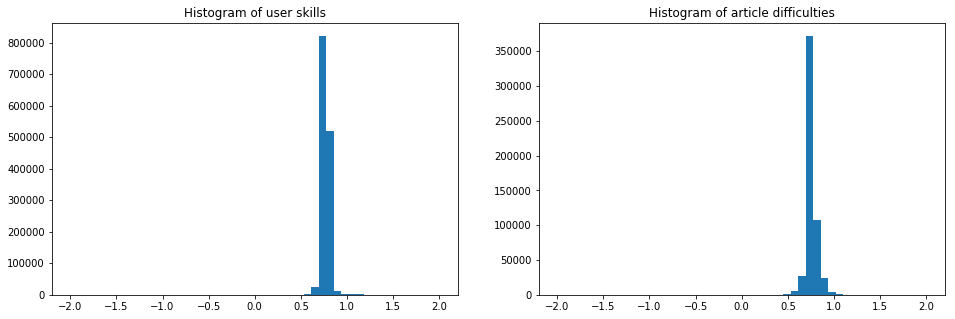

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5), sharex=True)

ax1.hist(skills, bins=np.linspace(-2, 2, num=50))
ax1.set_title("Histogram of user skills")

ax2.hist(difficulties, bins=np.linspace(-2, 2, num=50))
ax2.set_title("Histogram of article difficulties")

In [11]:
with session.as_default():
    probs = model.probability.eval(feed_dict=feed["test"])

Text(0.5,1,'Histogram of model estimates')

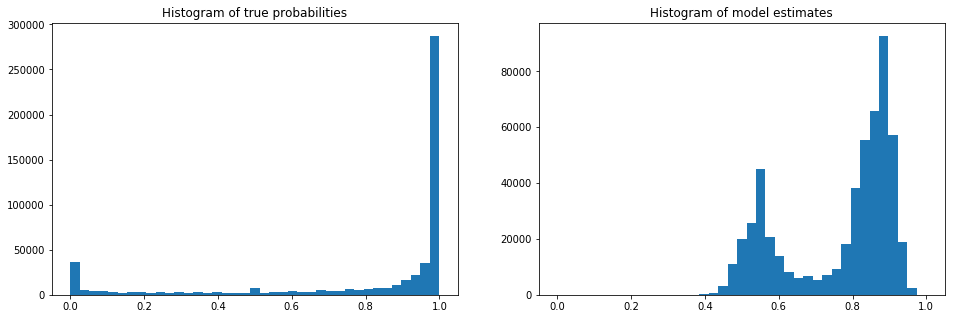

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5), sharex=True)

ax1.hist(test_data[2], bins=np.linspace(0, 1, num=40))
ax1.set_title("Histogram of true probabilities")

ax2.hist(probs, bins=np.linspace(0, 1, num=40))
ax2.set_title("Histogram of model estimates")

## Quantitative results

In [13]:
labels = (test_data[2] < 0.5).astype(int)
precision, recall, _ = precision_recall_curve(labels, 1 - probs)
auc = average_precision_score(labels, 1 - probs)

print("proportion of positive labels: {:.3f}".format(sum(labels) / len(labels)))

proportion of positive labels: 0.168


Text(0.5,1,'Precision-recall curve (AUC: 0.471)')

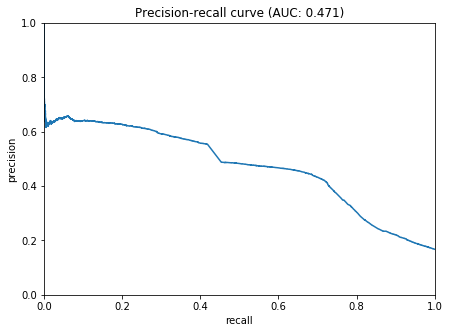

In [14]:
fig, ax = plt.subplots(figsize=(7.0, 5.0))
ax.plot(recall, precision)
ax.set_xlim(xmin=0.0, xmax=1.0)
ax.set_ylim(ymin=0.0, ymax=1.0)
ax.set_ylabel("precision")
ax.set_xlabel("recall")
ax.set_title("Precision-recall curve (AUC: {:.3})".format(auc))

## Save data for plotting, etc.

In [15]:
# Save TensorFlow model
saver = tf.train.Saver()
saver.save(session, "../trained-models/trwiki/whitehill.ckpt")

'../trained-models/trwiki/whitehill.ckpt'

In [16]:
data = {
    "y_true": test_data[2],
    "y_pred": probs,
}
with open("../data/trwiki-whitehill-pred.pickle", "wb") as f:
    pickle.dump(data, f)